In [3]:
# Script to read the WGS FASTA files, select sequences based on the number of unique EPI_IDs 
# in the smallest FASTA file, and write the filtered sequences to new FASTA files in the output directory.

import os
import random
from Bio import SeqIO

def extract_epi_id(header):
    """
    Extract the EPI_ID from the FASTA header. 
    EPI_ID is the second section in the header separated by '|'.
    """
    return header.split('|')[1]

def is_valid_sequence(sequence):
    """
    Check if a sequence contains only 'A', 'T', 'G', 'C'.
    """
    valid_bases = {'A', 'T', 'G', 'C'}
    return set(sequence.upper()).issubset(valid_bases)

def get_unique_epi_ids(fasta_file):
    """
    Get a set of unique EPI_IDs from the FASTA file, considering only sequences
    that are complete (contain only 'A', 'T', 'G', 'C').
    """
    epi_ids = set()
    for record in SeqIO.parse(fasta_file, "fasta"):
        if is_valid_sequence(record.seq):  # Only add EPI_ID if the sequence is valid
            epi_id = extract_epi_id(record.description)
            epi_ids.add(epi_id)
    return epi_ids

def filter_sequences_by_epi_ids(fasta_file, selected_epi_ids):
    """
    Filter sequences in a FASTA file by selected EPI_IDs and ensure that only sequences
    containing 'A', 'T', 'G', 'C' are included.
    """
    selected_sequences = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        epi_id = extract_epi_id(record.description)
        if epi_id in selected_epi_ids and is_valid_sequence(record.seq):
            selected_sequences.append(record)
    return selected_sequences

def write_fasta_file(sequences, output_file):
    """
    Write sequences to a FASTA file and print the number of unique EPI_IDs written.
    """
    with open(output_file, 'w') as f:
        SeqIO.write(sequences, f, "fasta")
    
    # Count the number of unique EPI_IDs in the written sequences
    unique_epi_ids = {extract_epi_id(seq.description) for seq in sequences}
    print(f"Written {len(sequences)} sequences and {len(unique_epi_ids)} unique EPI_IDs to {output_file}")

if __name__ == "__main__":
    # Path to the directory containing WGS FASTA files
    wgs_dir = "/mmfs1/projects/changhui.yan/DeewanB/DNABert2_rnaseq/genome_files/IAV_WGS/"
    
    # Output directory for filtered FASTA files
    output_dir = "/mmfs1/projects/changhui.yan/DeewanB/DNABert2_rnaseq/genome_files/finetune_ART_sims/iav_finetune/"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # List all FASTA files in the WGS directory
    fasta_files = [os.path.join(wgs_dir, f) for f in os.listdir(wgs_dir) if f.endswith('.fasta')]

    # Get the EPI_ID counts for each FASTA file and find the file with the least unique EPI_IDs
    epi_id_counts = {fasta: len(get_unique_epi_ids(fasta)) for fasta in fasta_files}
    min_epi_file = min(epi_id_counts, key=epi_id_counts.get)
    min_epi_count = epi_id_counts[min_epi_file]

    print(f"Selected FASTA file with the least number of EPI_IDs: {min_epi_file} with {min_epi_count} EPI_IDs.")

    # Get the unique EPI_IDs from the selected file
    selected_epi_ids_from_min = get_unique_epi_ids(min_epi_file)

    # Select the same number of EPI_IDs from other FASTA files
    selected_epi_ids = {}
    for fasta_file in fasta_files:
        epi_ids = list(get_unique_epi_ids(fasta_file))
        random.shuffle(epi_ids)
        selected_epi_ids[fasta_file] = set(epi_ids[:min_epi_count])

    # Write the subsetted sequences to new FASTA files
    for fasta_file in fasta_files:
        filtered_sequences = filter_sequences_by_epi_ids(fasta_file, selected_epi_ids[fasta_file])
        output_fasta_file = os.path.join(output_dir, os.path.basename(fasta_file))
        write_fasta_file(filtered_sequences, output_fasta_file)

    print("Subsetted FASTA files created.")

Selected FASTA file with the least number of EPI_IDs: /mmfs1/projects/changhui.yan/DeewanB/DNABert2_rnaseq/genome_files/IAV_WGS/gisaid_influenzaA_H7N9.fasta with 2498 EPI_IDs.
Written 18600 sequences and 2498 unique EPI_IDs to /mmfs1/projects/changhui.yan/DeewanB/DNABert2_rnaseq/genome_files/finetune_ART_sims/iav_finetune/gisaid_influenzaA_H5N1.fasta
Written 19711 sequences and 2498 unique EPI_IDs to /mmfs1/projects/changhui.yan/DeewanB/DNABert2_rnaseq/genome_files/finetune_ART_sims/iav_finetune/gisaid_influenzaA_H1N1.fasta
Written 19293 sequences and 2498 unique EPI_IDs to /mmfs1/projects/changhui.yan/DeewanB/DNABert2_rnaseq/genome_files/finetune_ART_sims/iav_finetune/gisaid_influenzaA_H3N2.fasta
Written 18694 sequences and 2498 unique EPI_IDs to /mmfs1/projects/changhui.yan/DeewanB/DNABert2_rnaseq/genome_files/finetune_ART_sims/iav_finetune/gisaid_influenzaA_H7N9.fasta
Written 19040 sequences and 2498 unique EPI_IDs to /mmfs1/projects/changhui.yan/DeewanB/DNABert2_rnaseq/genome_files

In [1]:
#PATH1) Script to take subsetted FASTA files created by Script 1 and perform RNA-Seq simulation using 
# ART simulator, generating 10X coverage reads for each readlength lengths (50, 75, 100, 150, and 250 base pairs)
# without paired end
import os
import subprocess
from Bio import SeqIO

def simulate_rnaseq_with_art(art_executable, reference_genomes, fq_file_prefixes, output_dir, read_length, coverage_depth, error_profile, paired_end=False):
    """
    Simulate RNA-Seq reads using ART for a list of reference genomes and modify headers.
    """
    for ref_genome, fq_prefix in zip(reference_genomes, fq_file_prefixes):
        
        ref_base_name = os.path.basename(ref_genome).split('.')[0]
        output_prefix = os.path.join(output_dir, f"{ref_base_name}_{read_length}bp")

        print(f"Running ART for {ref_genome} with {read_length} bp reads to achieve {coverage_depth}X coverage using {error_profile} profile...")

        # Build the ART command
        command = [
            art_executable,
            '-ss', error_profile,  # Sequencing system
            '-i', ref_genome,      # Input reference genome
            '-l', str(read_length),  # Read length
            '-f', str(coverage_depth),  # Coverage depth
            '-o', output_prefix    # Output prefix
        ]

        if paired_end:
            command.append('-p')

        # Run ART command
        try:
            subprocess.run(command, check=True)
        except subprocess.CalledProcessError as e:
            print(f"Error occurred while running ART on {ref_genome}: {e}")
            continue

        # Modify the FASTQ headers by prepending the fq_file_prefix
        modify_fastq_headers(f"{output_prefix}.fq", fq_prefix)

        # Count and print the number of fragments generated in the output .fq file
        count_fragments_in_fq(f"{output_prefix}.fq")

    print(f"Simulation completed for {read_length} bp reads.")

def modify_fastq_headers(fq_file, prefix):
    """
    Modify FASTQ file headers to prepend the given prefix.
    """
    modified_fq_file = f"{fq_file}_modified.fq"
    with open(fq_file, 'r') as infile, open(modified_fq_file, 'w') as outfile:
        counter = 1
        for i, line in enumerate(infile):
            if i % 4 == 0:  # Header line
                original_header = line.strip()
                modified_header = f"@{prefix}|{counter} {original_header[1:]}"
                outfile.write(f"{modified_header}\n")
                counter += 1
            else:
                outfile.write(line)
    os.replace(modified_fq_file, fq_file)
    print(f"Modified FASTQ headers for {fq_file}")

def count_fragments_in_fq(fq_file):
    """
    Count the number of fragments in a FASTQ file.
    """
    with open(fq_file, 'r') as f:
        total_lines = sum(1 for _ in f)
    total_fragments = total_lines // 4
    print(f"File {fq_file} contains {total_fragments} fragments (reads).")

if __name__ == "__main__":
    # Path to the ART executable
    art_executable = "/mmfs1/projects/changhui.yan/DeewanB/ART_sim/art_bin_MountRainier/art_illumina"

    # Path to the subsetted FASTA files created by Script 1
    subsetted_fasta_dir = "/mmfs1/projects/changhui.yan/DeewanB/DNABert2_rnaseq/genome_files/finetune_ART_sims/iav_finetune"

    # Output directory for simulated reads
    output_dir = "/mmfs1/projects/changhui.yan/DeewanB/DNABert2_rnaseq/genome_files/finetune_ART_sims/iav_finetune_150_250"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # List all subsetted FASTA files
    fasta_files = [os.path.join(subsetted_fasta_dir, f) for f in os.listdir(subsetted_fasta_dir) if f.endswith('.fasta')]

    # Define read lengths to simulate
    read_lengths = [50, 75, 100, 150, 250]
    
    
    # Define coverage depth (10X)
    coverage_depth = 3

    # Prefixes for each genome type
    fq_file_prefixes = [os.path.splitext(os.path.basename(f))[0] for f in fasta_files]

    # Perform RNA-Seq simulation for each read length
    for read_length in read_lengths:
        test_output_dir = os.path.join(output_dir, f"testdata_{read_length}bp")
        if not os.path.exists(test_output_dir):
            os.makedirs(test_output_dir)

        # Adjust error profile based on read length
        error_profile = 'HS20' if read_length <= 100 else 'MSv3'

        # Run the simulation for each dataset
        simulate_rnaseq_with_art(
            art_executable=art_executable,
            reference_genomes=fasta_files,
            fq_file_prefixes=fq_file_prefixes,
            output_dir=test_output_dir,
            read_length=read_length,
            coverage_depth=coverage_depth,
            error_profile=error_profile,
            paired_end=False
        )

    print("All simulations are completed.")

Running ART for /mmfs1/projects/changhui.yan/DeewanB/DNABert2_rnaseq/genome_files/finetune_ART_sims/iav_finetune/gisaid_influenzaA_H5N1.fasta with 150 bp reads to achieve 10X coverage using MSv3 profile...

    ====================ART====================
             ART_Illumina (2008-2016)          
          Q Version 2.5.8 (June 7, 2016)       
     Contact: Weichun Huang <whduke@gmail.com> 
    -------------------------------------------

                  Single-end Simulation

Total CPU time used: 61.79

The random seed for the run: 1727362926

Parameters used during run
	Read Length:	150
	Genome masking 'N' cutoff frequency: 	1 in 150
	Fold Coverage:            10X
	Profile Type:             Combined
	ID Tag:                   

Quality Profile(s)
	First Read:   MiSeq v3 Length 251 R1 (built-in profile) 

Output files

  FASTQ Sequence File:
	/mmfs1/projects/changhui.yan/DeewanB/DNABert2_rnaseq/genome_files/finetune_ART_sims/iav_finetune_150_250/testdata_150bp/gisaid_influenzaA

In [7]:
# PATH2) Script to take subsetted FASTA files created by Script 1 and perform RNA-Seq simulation using 
# ART simulator, generating 1X coverage reads for each readlength lengths (50, 75, 100, 150, and 250 base pairs)
# with paired end reads

import os
import subprocess
from Bio import SeqIO

def simulate_rnaseq_with_art(art_executable, reference_genomes, fq_file_prefixes, output_dir, read_length, coverage_depth, error_profile, paired_end=False):
    """
    Simulate RNA-Seq reads using ART for a list of reference genomes and modify headers.
    """
    # Adjust fragment length and standard deviation based on read length
    if read_length == 50:
        mean_fragment_length = 200
        fragment_std_dev = 20
    elif read_length == 75:
        mean_fragment_length = 250
        fragment_std_dev = 25
    elif read_length == 100:
        mean_fragment_length = 300
        fragment_std_dev = 30
    elif read_length == 150:
        mean_fragment_length = 400
        fragment_std_dev = 40
    elif read_length == 250:
        mean_fragment_length = 550
        fragment_std_dev = 50
    else:
        mean_fragment_length = 300  # Default value
        fragment_std_dev = 30

    for ref_genome, fq_prefix in zip(reference_genomes, fq_file_prefixes):
        
        ref_base_name = os.path.basename(ref_genome).split('.')[0]
        output_prefix = os.path.join(output_dir, f"{ref_base_name}_{read_length}bp")

        print(f"Running ART for {ref_genome} with {read_length} bp reads to achieve {coverage_depth}X coverage using {error_profile} profile...")

        # Build the ART command
        command = [
            art_executable,
            '-ss', error_profile,                # Sequencing system
            '-i', ref_genome,                    # Input reference genome
            '-l', str(read_length),              # Read length
            '-f', str(coverage_depth),           # Coverage depth
            '-o', output_prefix,                 # Output prefix
            '-m', str(mean_fragment_length),     # Mean fragment length
            '-s', str(fragment_std_dev)          # Fragment length standard deviation
        ]

        if paired_end:
            command.append('-p')

        # Run ART command
        try:
            subprocess.run(command, check=True)
        except subprocess.CalledProcessError as e:
            print(f"Error occurred while running ART on {ref_genome}: {e}")
            continue

        # Modify the FASTQ headers for both paired-end files
        modify_fastq_headers(f"{output_prefix}1.fq", fq_prefix)  # Forward reads
        modify_fastq_headers(f"{output_prefix}2.fq", fq_prefix)  # Reverse reads

        # Count and print the number of fragments generated in both output .fq files
        count_fragments_in_fq(f"{output_prefix}1.fq")  # Forward reads
        count_fragments_in_fq(f"{output_prefix}2.fq")  # Reverse reads

    print(f"Simulation completed for {read_length} bp reads.")

def modify_fastq_headers(fq_file, prefix):
    """
    Modify FASTQ file headers to prepend the given prefix (label_name) while keeping the rest of the original header unchanged.
    This function handles headers with multiple sections, including those that vary in format.
    """
    modified_fq_file = f"{fq_file}_modified.fq"
    with open(fq_file, 'r') as infile, open(modified_fq_file, 'w') as outfile:
        for i, line in enumerate(infile):
            if i % 4 == 0:  # Header line (every 4th line starting from 0)
                original_header = line.strip()  # Keep the entire original header
                modified_header = f"@{prefix}|{original_header[1:]}"  # Prepend the prefix after the "@" symbol, leaving the rest intact
                outfile.write(f"{modified_header}\n")
            else:
                outfile.write(line)
    os.replace(modified_fq_file, fq_file)
    print(f"Modified FASTQ headers for {fq_file}")

def count_fragments_in_fq(fq_file):
    """
    Count the number of fragments in a FASTQ file.
    """
    with open(fq_file, 'r') as f:
        total_lines = sum(1 for _ in f)
    total_fragments = total_lines // 4
    print(f"File {fq_file} contains {total_fragments} fragments (reads).")

if __name__ == "__main__":
    # Path to the ART executable
    art_executable = "/mmfs1/projects/changhui.yan/DeewanB/ART_sim/art_bin_MountRainier/art_illumina"

    # Path to the subsetted FASTA files created by Script 1
    subsetted_fasta_dir = "/mmfs1/projects/changhui.yan/DeewanB/DNABert2_rnaseq/genome_files/finetune_ART_sims/iav_finetune"

    # Output directory for simulated reads
    output_dir = "/mmfs1/projects/changhui.yan/DeewanB/DNABert2_rnaseq/genome_files/finetune_ART_sims/iav_finetune"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # List all subsetted FASTA files
    fasta_files = [os.path.join(subsetted_fasta_dir, f) for f in os.listdir(subsetted_fasta_dir) if f.endswith('.fasta')]

    # Define read lengths to simulate
    read_lengths = [50, 75, 100, 150, 250]
    
    # Define coverage depth (3X)
    coverage_depth = 3

    # Prefixes for each genome type
    fq_file_prefixes = [os.path.splitext(os.path.basename(f))[0] for f in fasta_files]

    # Perform RNA-Seq simulation for each read length
    for read_length in read_lengths:
        test_output_dir = os.path.join(output_dir, f"testdata_{read_length}bp")
        if not os.path.exists(test_output_dir):
            os.makedirs(test_output_dir)

        # Adjust error profile based on read length
        error_profile = 'HS20' if read_length <= 100 else 'MSv3'

        # Run the simulation for each dataset
        simulate_rnaseq_with_art(
            art_executable=art_executable,
            reference_genomes=fasta_files,
            fq_file_prefixes=fq_file_prefixes,
            output_dir=test_output_dir,
            read_length=read_length,
            coverage_depth=coverage_depth,
            error_profile=error_profile,
            paired_end=True  # Paired-end reads
        )

    print("All simulations are completed.")

Running ART for /mmfs1/projects/changhui.yan/DeewanB/DNABert2_rnaseq/genome_files/finetune_ART_sims/iav_finetune/gisaid_influenzaA_H5N1.fasta with 50 bp reads to achieve 3X coverage using HS20 profile...

    ====================ART====================
             ART_Illumina (2008-2016)          
          Q Version 2.5.8 (June 7, 2016)       
     Contact: Weichun Huang <whduke@gmail.com> 
    -------------------------------------------

                  Paired-end sequencing simulation

Total CPU time used: 30.01

The random seed for the run: 1728170617

Parameters used during run
	Read Length:	50
	Genome masking 'N' cutoff frequency: 	1 in 50
	Fold Coverage:            3X
	Mean Fragment Length:     200
	Standard Deviation:       20
	Profile Type:             Combined
	ID Tag:                   

Quality Profile(s)
	First Read:   HiSeq 2000 Length 100 R1 (built-in profile) 
	First Read:   HiSeq 2000 Length 100 R2 (built-in profile) 

Output files

  FASTQ Sequence Files:
	 the 1s

In [8]:
# Python script to process .fq files generated in all simulated data directories, 
# extracts sequences, epi_id values, and label_name values from sequence headers,
# and writes it to a finetuning CSV file with paired end reads

import os
import csv
from Bio import SeqIO

# Map label_name to label_name
label_mapping = {
    'gisaid_influenzaA_H1N1': 'influenza_a_H1N1',
    'gisaid_influenzaA_H1N2': 'influenza_a_H1N2',
    'gisaid_influenzaA_H3N2': 'influenza_a_H3N2',
    'gisaid_influenzaA_H5N1': 'influenza_a_H5N1',
    'gisaid_influenzaA_H7N9': 'influenza_a_H7N9',
    'gisaid_influenzaA_H9N2': 'influenza_a_H9N2'
}

def map_label_name(label):
    """
    Map the label_name to the appropriate IAV class.
    """
    return label_mapping.get(label, label)  # Return the mapped label or the original if not found

def extract_info_from_fq(fq_file):
    """
    Extract sequences, label_name, and EPI_ID from a .fq file for paired-end reads.
    """
    extracted_data = []
    with open(fq_file, 'r') as handle:
        for record in SeqIO.parse(handle, "fastq"):
            header_parts = record.description.split('|')
            if len(header_parts) >= 3:
                label_name = map_label_name(header_parts[0])
                epi_id = header_parts[2]
                sequence = str(record.seq)
                extracted_data.append([label_name, epi_id, sequence])
    return extracted_data

def process_fq_files(fq_dir, output_csv_file, allowed_dirs):
    """
    Process .fq files in specific subdirectories and extract relevant information.
    
    Parameters:
    - fq_dir: The base directory containing all testdata directories.
    - output_csv_file: The CSV file to write extracted data.
    - allowed_dirs: A list of directories (relative to fq_dir) to process.
    """
    all_extracted_data = []

    # Traverse all directories and collect .fq files only from allowed directories, excluding single_end subdirectories
    for allowed_dir in allowed_dirs:
        dir_path = os.path.join(fq_dir, allowed_dir)
        if os.path.exists(dir_path):
            for root, _, files in os.walk(dir_path):
                # Skip the single_end subdirectory
                if 'single_end' in root:
                    continue

                for file in files:
                    if file.endswith(".fq"):
                        fq_file_path = os.path.join(root, file)
                        print(f"Processing {fq_file_path}...")
                        extracted_data = extract_info_from_fq(fq_file_path)
                        all_extracted_data.extend(extracted_data)
        else:
            print(f"Directory {dir_path} does not exist.")

    # Write all extracted data to the CSV file
    with open(output_csv_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['label_name', 'EPI_ID', 'sequence'])  # CSV header
        writer.writerows(all_extracted_data)

    print(f"Data extraction completed. Written to {output_csv_file}")

if __name__ == "__main__":
    # Define the directory containing the testdata directories with .fq files
    fq_dir = "/mmfs1/projects/changhui.yan/DeewanB/DNABert2_rnaseq/genome_files/finetune_ART_sims/iav_finetune"

    # Define the output CSV file path
    output_csv_file = os.path.join(fq_dir, "ART_simulated_iav_finetune_3Xcoverage_pairedend.csv")

    # List of allowed directories to process
    allowed_dirs = ["testdata_50bp", "testdata_75bp", "testdata_100bp", "testdata_150bp", "testdata_250bp"]

    # Process all .fq files from the allowed directories and write the extracted data to the CSV file
    process_fq_files(fq_dir, output_csv_file, allowed_dirs)

Processing /mmfs1/projects/changhui.yan/DeewanB/DNABert2_rnaseq/genome_files/finetune_ART_sims/iav_finetune/testdata_50bp/gisaid_influenzaA_H9N2_50bp1.fq...
Processing /mmfs1/projects/changhui.yan/DeewanB/DNABert2_rnaseq/genome_files/finetune_ART_sims/iav_finetune/testdata_50bp/gisaid_influenzaA_H3N2_50bp1.fq...
Processing /mmfs1/projects/changhui.yan/DeewanB/DNABert2_rnaseq/genome_files/finetune_ART_sims/iav_finetune/testdata_50bp/gisaid_influenzaA_H9N2_50bp2.fq...
Processing /mmfs1/projects/changhui.yan/DeewanB/DNABert2_rnaseq/genome_files/finetune_ART_sims/iav_finetune/testdata_50bp/gisaid_influenzaA_H5N1_50bp1.fq...
Processing /mmfs1/projects/changhui.yan/DeewanB/DNABert2_rnaseq/genome_files/finetune_ART_sims/iav_finetune/testdata_50bp/gisaid_influenzaA_H1N1_50bp2.fq...
Processing /mmfs1/projects/changhui.yan/DeewanB/DNABert2_rnaseq/genome_files/finetune_ART_sims/iav_finetune/testdata_50bp/gisaid_influenzaA_H3N2_50bp2.fq...
Processing /mmfs1/projects/changhui.yan/DeewanB/DNABert2_r

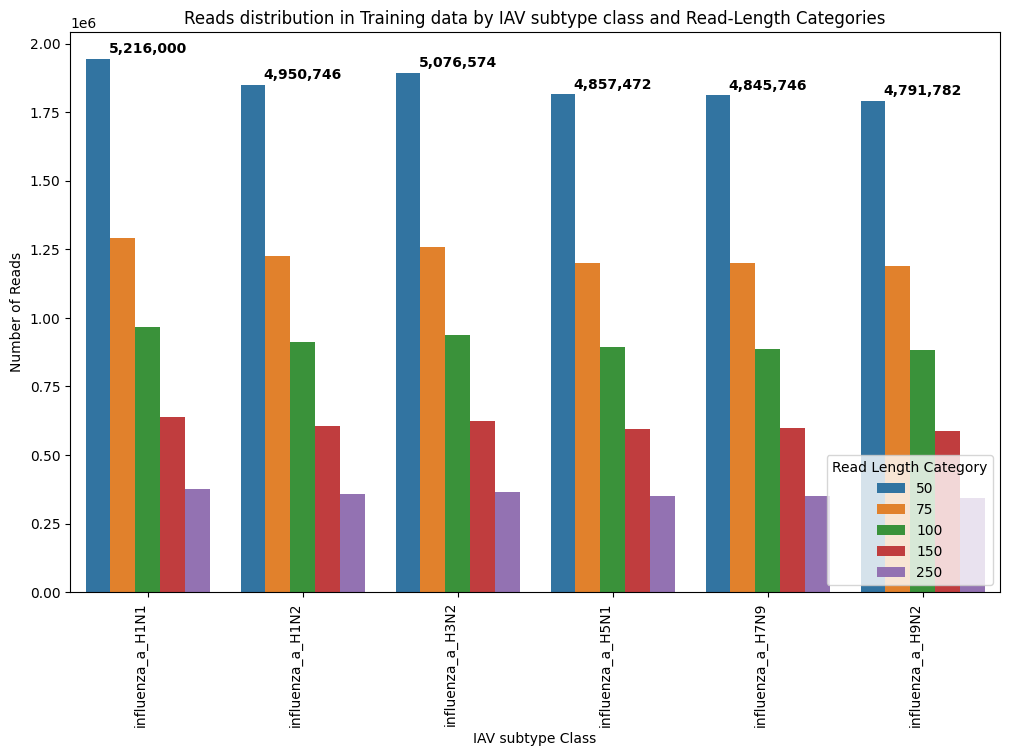

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File path to the CSV
csv_path = "/mmfs1/projects/changhui.yan/DeewanB/DNABert2_rnaseq/genome_files/finetune_ART_sims/iav_finetune/ART_simulated_iav_finetune_3Xcoverage_pairedend.csv"

# Load the CSV data
df = pd.read_csv(csv_path)

# Define function to categorize read lengths into specific bins (50, 75, 100, 150, 250 bps)
def categorize_read_length(seq):
    length = len(seq)
    if length == 50:
        return "50"
    elif length == 75:
        return "75"
    elif length == 100:
        return "100"
    elif length == 150:
        return "150"
    elif length == 250:
        return "250"
    else:
        return "Other"

# Apply the function to create a new column with the categorized read length
df['Read_Length_Category'] = df['sequence'].apply(categorize_read_length)

# Filter the data to include only sequences of lengths 50, 75, 100, 150, and 250
filtered_df = df[df['Read_Length_Category'].isin(['50', '75', '100', '150', '250'])]

# Group the data by `label_name` and `Read_Length_Category` and count the number of reads
grouped_data = filtered_df.groupby(['label_name', 'Read_Length_Category']).size().reset_index(name='Count')

# Calculate the total number of reads for each label_name
total_reads = grouped_data.groupby('label_name')['Count'].sum().reset_index()

# Precompute the max value for each label_name for annotation purposes
max_heights = grouped_data.groupby('label_name')['Count'].max()

# Create a bar plot with seaborn and sort the read lengths
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(
    x='label_name', 
    y='Count', 
    hue='Read_Length_Category', 
    data=grouped_data, 
    hue_order=['50', '75', '100', '150', '250']  # Sorting based on read lengths
)

# Annotate the total number of reads on top of the bars for each label_name
for i, label in enumerate(total_reads['label_name']):
    total_count = total_reads[total_reads['label_name'] == label]['Count'].values[0]
    
    # Get the precomputed height of the tallest bar for this label_name
    height = max_heights[label]
    
    # Annotate the total number of reads just above the tallest bar
    bar_plot.text(i, height + 10000, f'{total_count:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add labels and title
plt.xlabel('IAV subtype Class')
plt.ylabel('Number of Reads')
plt.title('Reads distribution in Training data by IAV subtype class and Read-Length Categories')
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for readability
plt.legend(title='Read Length Category', loc='lower right')

# Manually adjust layout to give more space for title and labels
plt.subplots_adjust(top=0.9, bottom=0.2)  # Adjust the top and bottom margins

# Save and show the plot
plt.savefig("/mmfs1/projects/changhui.yan/DeewanB/DNABert2_rnaseq/genome_files/finetune_ART_sims/iav_finetune/iav_readlength.png")
plt.show()

In [ ]:
# Get the unique values from the 'label_name' column
unique_label_names = df['label_name'].unique()

# Print each unique value
print("Unique values in the 'label_name' column:")
for label_name in unique_label_names:
    print(label_name)